# Proof by Pixel




By Kaspar von Beelen and Daniel van Strien

© von/van van/von GmbH\*.

**Disclaimer**: Don't look to us (the present authors) for answers. Critically inspect the text and the code of this Notebook before believing a line (or word) of it.\*\* 

This Notebook arose as part of **our** learning process. It serves as a collection of temporary guidelines but ~~can~~ should be improved. 


... and that's where your contribution kicks in...

Like beer, **enjoy the tutorial with reservation!**

\*Gesellschaft mit beschränkter Haftung

\*\*Lastly, all typos (and other insults to the English language) are exclusively copyrighted by Kaspar von Beelen Ltd. 

# Part III: Processing and analysing historical maps

This notebook provides an introduction to image processing and analytics. We rehearse some skills from the previous Notebook but extend those by demonstrating how to manipulate images, prepare them for further analysis and compute some descriptive statistics.

Methodologically, we try to change the way you think about images, teaching how to translate the visual to the numerical (and vice versa).

To move from numbers to meaning, you need to understand the source material and the processes the act upon it.

More specifically, you learn to

- capture similarities and differences between images using descriptie statistics
- manipulate images and automatically establish which part (i.e. which region of pixels) contains valuable information, and which areas can be discarded as "boring".

This Notebook won't make you a wizard in computer vision, it will (hopefully) enable you to understand the value (and potential) of treating maps-as-data.

The Notebook expects basic knowledge of Python, but we try to fill the gaps with a few brief intermezzos explaining some basic data types.

Without further ado, let's start "image mining".

## Image Quality

### Opening Question: "Fit for purpose?"

The original images provided by the NLS are great: the level of detail allows you to almost see the furniture inside the houses. However, having such high-quality images implies some computational cost: each image packs numerous bytes, so many that it becomes almost impossible to work with them on a normal computer. 

Therefore, we resized the images for the Hackday. Working with .tifs that are larger than 500MB pushes Colab (the interface in front of you) to the edge of its capabilities--uploading a file simply takes too long (unless your patience dates from the _ancien régime_). 

The script to resize images can be found below in the appendix. For those who are a bit more comfortable with Python, feel free to copy-paste and experiment with other images.

All processed images are stored [here](https://drive.google.com/drive/folders/1br3Azp4VYGd1tJCE42TcCBN16xYhsWaR?usp=sharing)

The material we prepared can be found in the "quality_comparison" folder, which contains converted images at different quality thresholds (see also the previous Notebook):

- we changed the format from .tif to .jpeg
- changed the values of the fx/fy arguments to either 0.1, 0.5 and 1.0 (this is saved in the "q=" part of the file name)

Similar to the questions about OCR quality (*oh no, not again, not now*), we should be mindful that there is no straightforward distinction between "good" and "bad" quality--it ultimately depends on the purpose of the analysis ("good enough for what?").

With this in mind, please attentively inspect the images at different quality levels and

- What information gets lost (for example when zooming in)?
- What are the benefits of resizing the image?
- Compare the resized image to the original, which can be found on Azure.
- ***Optional***: select a few images from the Azure Storage Explorer and use the above script to resize the images. Inspect the output.



**Double-click** on this cell to write down your **answers**.

- intelligent answer 1
- intelligent answer 2
etc.

## Loading and displaying images in Colab



Before opening images in Colab, we have to upload maps using the pre-cooked Colab functionality.


- Go to the folder on [Google Drive](https://drive.google.com/drive/folders/1br3Azp4VYGd1tJCE42TcCBN16xYhsWaR?usp=sharing) and download all the folders/images to your computer.
- Run the code below
- Click on "Choose Files" and navigate to the **"converted" folder** you just downloaded.
- Select both files and click "Open"
- **Wait**, the percentages on the right-hand side indicates the progress (it can take a few minutes before the upload is complete.)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving 101965655_conv.jpeg to 101965655_conv.jpeg
Saving 101965742_conv.jpeg to 101965742_conv.jpeg
Saving 101965802.27_conv.jpeg to 101965802.27_conv.jpeg


### Vew an image in Colab

After running, the cell should tell you that the files you upload are "100% done".

To inspect the image in Colab run the cell below...

In [0]:
from IPython.display import Image

- Select the `Image()` function
- And copy-paste the image name between the parentheses
- Make sure the image name is enclosed in single or double quotation marks (" or  '')

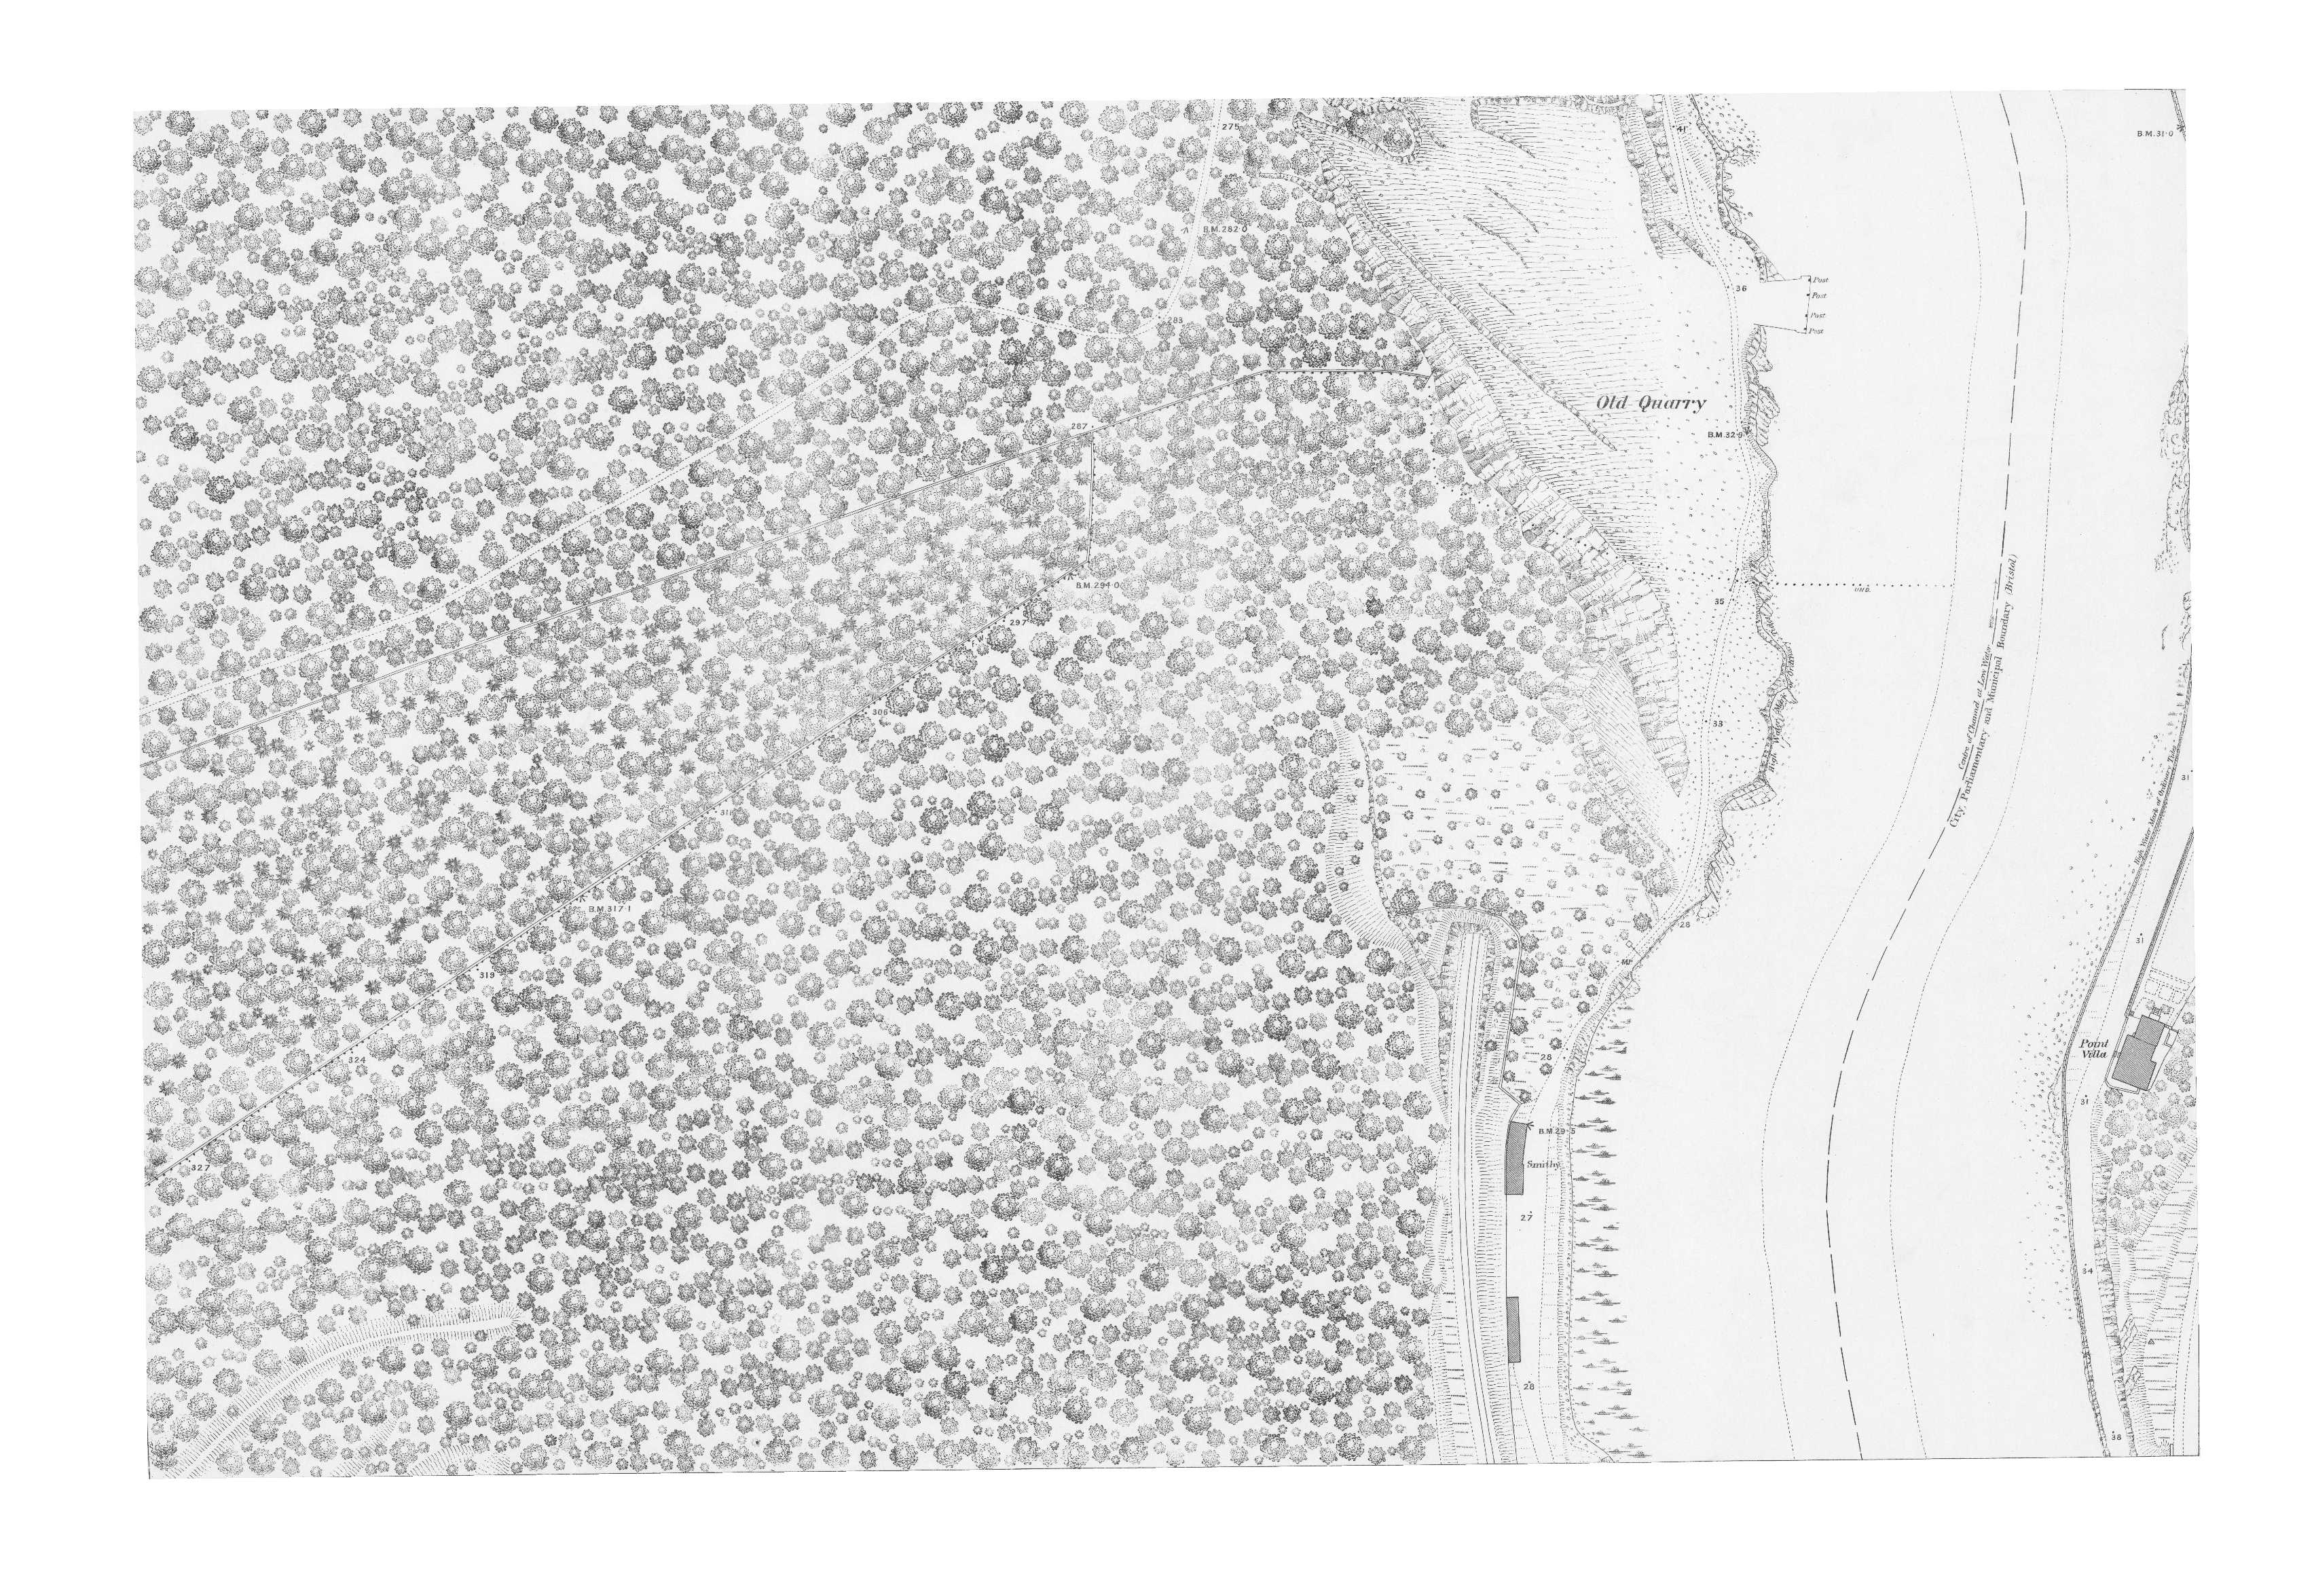

In [0]:
Image("101965742_conv.jpeg",width=500)

### Exercise

Please plot another maps. Use the code cell below.

In [0]:
# enter code here

The `Image` function we imported from the `IPython.display` library offers a simple tool for inspecting images in Colab. 

Below, however, we'll mostly rely on other libraries, `cv2` and `matplotlib` because these are easier to integrate into other scripts.

To use the libraries, we first have to load them into our Notebook:
- OpenCV (`cv2`, which we abbreviate as before to `cv`)
- `pyplot` from the `matplotlib` library (which we shorten to `plt`)

In [0]:
import cv2 as cv
import matplotlib.pyplot as plt

To read an image with OpenCV, we have to call the `imread` function from the `cv` library. For those new to Python, inspect the code and explanations to get a feeling for the syntax (which we'll repeat frequently).

- `image = <something here>` introduces a variable declaration, meaning that we'll store something in a variable with the name "image" (`image` effectively serves as a container that stores information for later reuse)

- `cv.imread` which follows the pattern `<library><dot><function>` 

- Everything between the parentheses are arguments (or parameters) of the `imread` function. The first argument is a string that tells `imread` **where** the file is located, the second argument says **how** it should open the file (i.e. as a grayscale image).

In [0]:
image = cv.imread("101965742_conv.jpeg",cv.IMREAD_GRAYSCALE)

Next, use `plt.imshow` to show the image in the Colab Notebook

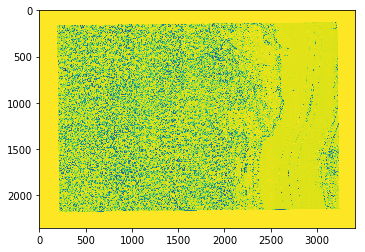

In [0]:
plt.imshow(image)

Ow, that looks weird! Hopefully, you remember from the previous Notebook that an image is mostly represented as a three-dimensional matrix (a tensor) in which each cell encodes the pixel intensity for one RGB channel. It seems like `imshow` thinks it has been fed with one layer from the RGB spectrum. To correct this behaviour, we have to pass the colour map explicitly. In this case way use `Greys_r`

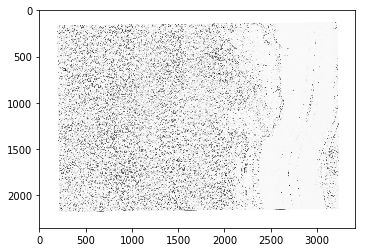

In [0]:
plt.imshow(image,cmap="Greys_r")

That looks better...


### Quick question

What do the numbers on the X and Y axis indicate?

Write your **answer** here.

### Exercise: Inverted Grey

- Store another uploaded image in a variable with the name `image2`
- Plot the image with `matplotlib` (use `Greys` as the colour map)

In [0]:
# enter code here

Congratulations, you are now ready to play with the maps!

## Images are numpy arrays

The previous cells have demonstrated how to read and plot an image. 

Now we turn to manipulating these images (doing stuff with them). We start with baby-steps, perform some math you should have been comfortable with from the age of six (or twelve, or whatever). Eventually, we move to more complex operations and end up implementing a line-detection algorithm (almost) from scratch.

Keeping the eye-candy for later, let's pose a more philosophical question: What, actually, is an image?

The previous Notebook already hinted at the answer, but let's confirm it by printing the `image` variable. 

In [0]:
print(image)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


We see only numbers--mostly 255. What is going on? What type of data is this?

We can ask Python to give us the answer calling the `type()` function.

In [0]:
type(image)

numpy.ndarray

Ok, but what is a `numpy.ndarray`? Use the inbuilt `help()` function to print the explanation. 

**Warning:** running the statement below will print a lot of documentation.

In [0]:
help(type(image))

Help on class ndarray in module numpy:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |

In short: an image is converted to "a multidimensional, homogeneous array" of fixed-size. 
- **multidimensional**: a greyscale image is a **matrix** (of two dimensions); a colour picture comes usually in three dimensions (a tensor of three RGB channels)
- **homogeneous**: the matrix or tensor can only contain one data type, in this case, an integer between 0 (a black pixel) and 255 (a white pixel). 
- **fixed size**: the matrix has a specific number of rows and columns

<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--oTgfo1EL--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://raw.githubusercontent.com/adhiraiyan/DeepLearningWithTF2.0/master/notebooks/figures/fig0201a.png">

The `ndim` and `shape` attributes give us insight into the dimensionality and the size of the image.

The general syntax for accessing attributes is:
`object.attribute`

In [0]:
image.ndim

2

In [0]:
image.shape

(2351, 3408)

`dtype` tells is which data type the matrix contains

In [0]:
image.dtype

dtype('uint8')

### Pixel Art: How to make a [mini-Malevich](https://www.tate.org.uk/art/artists/kazimir-malevich-1561/five-ways-look-malevichs-black-square)

Once we know the type and the contours of the data we are dealing with, let's inspect what we can do with this information.

A matrix in Python comes as a list of lists (also called a nested list), which is subsequently converted to a numpy.array. Run and inspect the code below to see how this works.

In [0]:
# load the numpy library, you'll need it!
import numpy as np

In [0]:
a_list = [255,255,255]
print(a_list)
print(type(a_list))
print(a_list[0])
print(type(a_list[0]))

[255, 255, 255]
<class 'list'>
255
<class 'int'>


In [0]:
a_list_of_lists = [[255,255,255],[255,0,255],[255,255,255]]
print(a_list_of_lists)
print(type(a_list_of_lists))
print(a_list_of_lists[0])
print(type(a_list_of_lists[0]))

[[255, 255, 255], [255, 0, 255], [255, 255, 255]]
<class 'list'>
[255, 255, 255]
<class 'list'>


In [0]:
a_numpy_matrix = np.array(a_list_of_lists)
print(a_numpy_matrix)
print(type(a_numpy_matrix))
print(a_numpy_matrix[0])
print(type(a_numpy_matrix[0]))

[[255 255 255]
 [255   0 255]
 [255 255 255]]
<class 'numpy.ndarray'>
[255 255 255]
<class 'numpy.ndarray'>


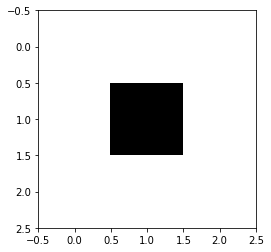

In [0]:
plt.imshow(a_numpy_matrix,cmap="Greys_r")

#### Exercise

By changing the values of the matrix (or numpy.array), you can draw any figure you like!

Can you, for example, draw an X and plot it?

In [0]:
# enter code here

### Slicing a matrix (or how to get your cake and eat it)

"Slicing" is a tool to select specific rows and columns from a matrix. 

Below we elaborate on some specific examples, but a more comprehensive overview on indexing and slicing can be found [here](https://stackoverflow.com/questions/509211/understanding-slice-notation)

In general, three symbols are important:

- square brackets `[` and`]`: applied to an object (i.e. image) you want to slice 
     - as in `image[]`
     
- colons `:` indicates the range of the slide: an integer on the left-hand side of the colon marks a starting point, an integer on the right-hand side tells Python where to stop:
     - as in `image[2:10]`
     
- commas `,` separates the different dimensions
     - as in `image[2:10,3:5]`


#### Question

Can you explain, in words, what information we capture by typing `image[2:10,3:5]`

Write **answer** here.

#### Question

What will the code below return?

In [0]:
image[:,:]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Slicing allows us to retrieve specific regions of an OS map. For example, the code below

- Selects rows 1000 till 1200 of the `image` matrix;
- Saves the selected rows in the `region` variable;
- Plots the result in grayscale

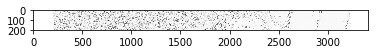

In [0]:
region = image[1000:1200,:].copy()
plt.imshow(region,cmap='Greys_r')

Some additional information on the code:
- The second colon in `image[1000:1200,:]` lacks a start and stop point, so it copies **all** the columns
- We append the `.copy()` method to the first line (to avoid manipulating the original map--all the transformations are applied to a **copy** of the selected region)

#### Exercise

Can you manually crop the image and discard the surrounding white border region?

Hint: you'll need to apply the slicing operation to both dimensions!

In [0]:
# enter code here

The indexing/slicing notation provides a convenient tool for block-wise segmentation. The example below cuts a square from the map, which we'll inspect and dissect in depth below.

Please note that we added one line of code to enlargen the image. 
- `plt.figure(figsize=(7,7))` you can change the numbers of the `figsize` parameter to make the image smaller or larger
- another way of making the image more visible is to increase the `dpi` (dots per inch) nob (as in `dpi=100`)

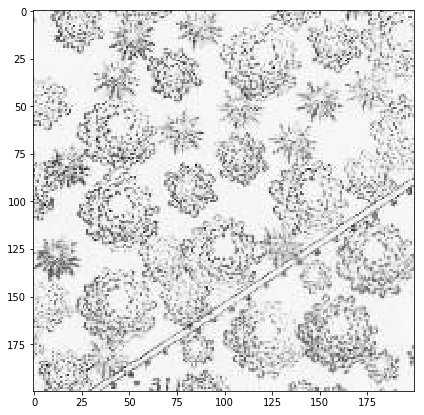

In [0]:
segment2 = image[1000:1200,1000:1200].copy()
plt.figure(figsize=(7,7))
plt.imshow(segment2,cmap='Greys_r')

## Images and Matrix Operations

As images are matrices (in which each cell stores the intensity of a pixel) we can subject the images to various algebraic operations and other manipulations. 

The extent to which these transformations are useful depends on the question at hand. When going through the examples below, try to understand how they may serve some research purpose.


### .sort()

Oftentimes, we want to rank our information. For example, ranking words by their length or frequency is common in language processing. The same applies to images, we can sort pixels by their intensity. 

Let's select two squares from the map, sort the pixels by intensity and compare the results of these transformations.

This involves the following steps:

- select a square region (of similar size) using slicing notation
- sort the pixels along a certain dimension
- plot the results

We select two blocks using the following coordinates:

     - `region 1: [1000:1200,1000:1200]`
     - `region 2: [1700:1900,2100:2300]`
     
Save these blocks in variables with names `region1` and `region2`

**Important**: don't forget to use `copy()` as in the previous examples

In [0]:
region1 = image[1000:1200,1000:1200].copy()
region2 = image[1700:1900,2100:2300].copy()

We can plot the figures next to each other with the `subplots` function.


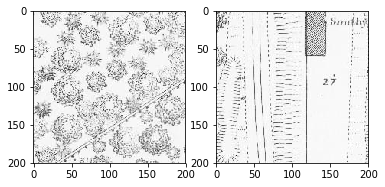

In [0]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(region1, cmap='Greys_r')
axarr[1].imshow(region2, cmap='Greys_r')

After choosing specific regions of the map, we can sort the matrix. Please note the `axis=0` in the statements below. This argument tells Python along which dimension it has to sort the pixels (please remember that a matrix is two-dimensional, i.e. it has rows and columns, so you have to tell Python if you want to sort row-wise or column-wise). The figure below shows how this works: effectively we are asking Python to sort all the values along the `row` dimension.

<img src="https://vrzkj25a871bpq7t1ugcgmn9-wpengine.netdna-ssl.com/wp-content/uploads/2018/11/numpy-arrays-have-axes.png">

In [0]:
region1.sort(axis=0)
region2.sort(axis=0)

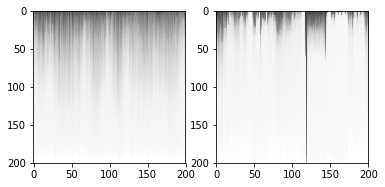

In [0]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(region1, cmap='Greys_r')
axarr[1].imshow(region2, cmap='Greys_r')

#### Question

In what sense does `.sort()` provide us with an interesting transformation of the input image? In what way does it make differences/similarities between the images more visible?

Write **answer** here.

#### Exercise

- Select two more patches in the map
- Sort the values along the `axis=1` dimension
- Plot the results
- Sort the values along the `axis=0` dimension
- Plot the results

In [0]:
# Enter code here

### Summary statistics

We can obtain a similar view on the images by computing the mean pixel intensity along a certain axis (i.e. row mean or column mean). To understand what we [mean with mean](https://en.wikipedia.org/wiki/Arithmetic_mean), we turn to a toy example.

Please run the code below:

- We first define and draw a 3x3 matrix 
- Compute the mean along `axis=0`
- Compute the mean along `axis=1`
- Plot the results

[[  2 200 205   0]
 [ 25   4   0   5]
 [  4 150  50   3]]


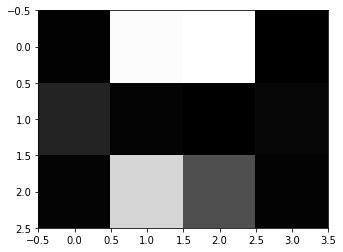

In [0]:
matrix = np.array([[2,200,205,0],[25,4,0,5],[4,150,50,3]])
print(matrix)
plt.imshow(matrix,cmap='Greys_r')

In [0]:
np.mean(matrix,axis=0)

array([ 10.33333333, 118.        ,  85.        ,   2.66666667])

In [0]:
np.mean(matrix,axis=1)

array([101.75,   8.5 ,  51.75])

#### Question

Explain how changing the `axis` argument influences the result.

Write **answer** here.

We can apply exactly the same code to other map segments.
Below we
- select two patches
- compute the mean along the first dimension
- plot the results

In [0]:
region1 = image[1000:1200,1000:1200].copy()
region2 = image[1700:1900,2100:2300].copy()

In [0]:
mean1 = np.mean(region1,axis=0)
mean2 = np.mean(region2,axis=0)


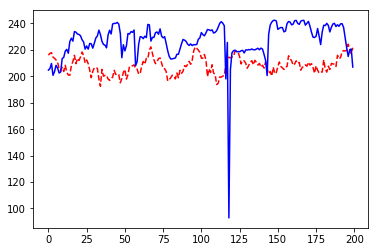

In [0]:
plt.plot(mean1, 'r--')
plt.plot(mean2, 'b-')
plt.show()

Computing the mean summarizes the distribution of values (in this case the pixel intensities) in one number. To understand how far or close all the values are located from the mean we can calculate the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) with `numpy.std`.

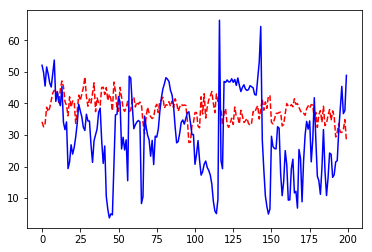

In [0]:
std1 = np.std(region1,axis=0)
std2 = np.std(region2,axis=0)
plt.plot(std1, 'r--')
plt.plot(std2, 'b-')
plt.show()


#### Question

How do these visualisations relate to the original image? Can we use these statistics to harvest interesting information from the maps; or compare them meaningfully?

Play around with other segments if you feel like!

Write **answer** here

In [0]:
# write code here

### Combining Matrices (Making patterns with maps)

For the more artistic among us, we explain how you can change contrast and combine images. It may not always serve a clear purpose, but it's fun, so please follow the recipes below

- Take two images (use index notation)

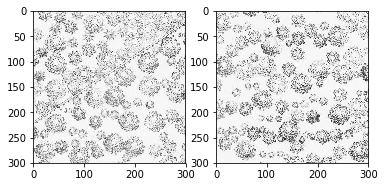

In [0]:
img_slice1 = image[1000:1300,1000:1300].copy()
img_slice2 = image[1500:1800,1200:1500].copy()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_slice1,cmap='Greys_r')
axarr[1].imshow(img_slice2,cmap='Greys_r')

Let's manipulate the contrast of these images by changing the values of the matrix in a rather brutal way. 
- If a pixel's intensity is larger then 200, set it to white (i.e. to 255),
- Otherwise, replace it with a black pixel (i.e. to 0)

- We can change pixel values using conditional expressions, such as smaller than `<` or bigger than `>`.

- In general, the syntax for changing values of an array based on a condition looks as follow

- `variable[condition] = new_value`

- To change the values of an array, by comparing the values to a specific threshold, you can use the following syntax.

- `variable[variable condition threshold] = new_value` (i.e. `var[var > 10] = 200`, sets all entries in `var` larger than 10 to 200)

In image analysis, this method is called **"global thresholding"**.


The code below applies this operation to the `img_slice1` variable.

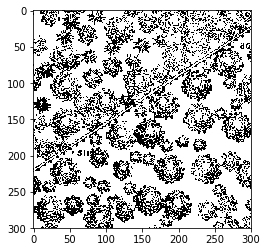

In [0]:
img_slice1[img_slice1 < 200] = 0
img_slice1[img_slice1 >= 200] = 255
plt.imshow(img_slice1,cmap="Greys_r")


By removing some of the nuances (discarding the gray pixels), some elements on the picture become more distinct. However, the value of the threshold is crucial here (I choose 200 because the output looks pretty, but you risk removing almost all information if chosen badly)

#### Exercise

Can you apply the same transformation to `img_slice2`?



In [0]:
# enter code here

Solution below.













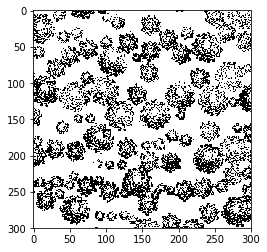

In [0]:
img_slice2[img_slice2 < 200] = 0
img_slice2[img_slice2 >= 200] = 255
plt.imshow(img_slice2,cmap="Greys_r")

So far we computed the mean (or standard deviation) for each column (or row) of the matrix. We can also apply similar operations to combine **two different** matrices. Put differently, we can add, multiply and subtract images! Yay!

We demonstrate how these matrix operations work with some toy examples. (Here we use `np.random.randint` to generate a matrix with values between 0 and 255. The number of rows and columns are defined by the `size` argument.)

In [0]:
matrix_1 = np.random.randint(0,high=255,size=(3,3),dtype=np.uint8)
print(matrix_1)

[[ 46 102 191]
 [166 191  74]
 [ 92   6 229]]


In [0]:
matrix_2 = np.random.randint(0,high=255,size=(3,3),dtype=np.uint8)
print(matrix_2)

[[ 99 228  82]
 [ 70 224 107]
 [207  82  50]]


#### Matrix Addition

In [0]:
matrix_added = matrix_1 + matrix_2
matrix_added

array([[145,  74,  17],
       [236, 159, 181],
       [ 43,  88,  23]], dtype=uint8)

####  Matrix substraction

In [0]:
matrix_subs = matrix_1 - matrix_2
matrix_subs

array([[203, 130, 109],
       [ 96, 223, 223],
       [141, 180, 179]], dtype=uint8)

#### Matrix multiplication

In [0]:
matrix_mult = matrix_1 * matrix_2
matrix_mult

array([[202, 216,  46],
       [100,  32, 238],
       [100, 236, 186]], dtype=uint8)

Let's see what happens when we retrieve two more segments (`img_slice3` and `img_slice4`) and add them up?

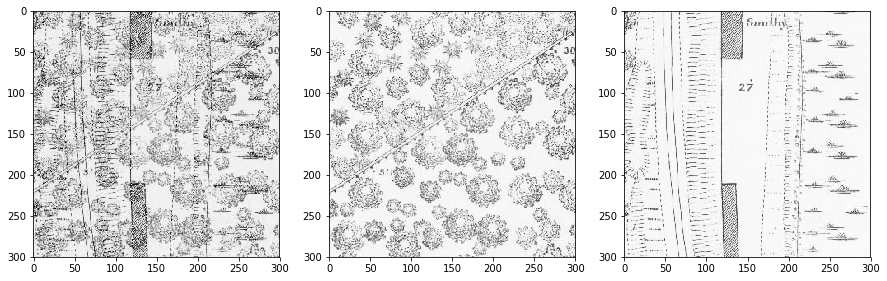

In [0]:
img_slice3 = image[1000:1300,1000:1300].copy()
img_slice4 = image[1700:2000,2100:2400].copy()
img_slice = img_slice3 + img_slice4
f,axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(img_slice,cmap='Greys_r')
axarr[1].imshow(img_slice3,cmap='Greys_r')
axarr[2].imshow(img_slice4,cmap='Greys_r')

#### Exercise
**Warning**: somewhat more difficult, please ignore if you are new to Python

For those who are a bit more comfortable with Python and Numpy. 
- Can you write a script that inverts the grayscale of an image?
- Apply this to the transformed `img_slice1` and `img_slice2` and overlay both images by adding them together 
- Use "Greys" as the `cmap` value



In [0]:
# add code here

Solution below.

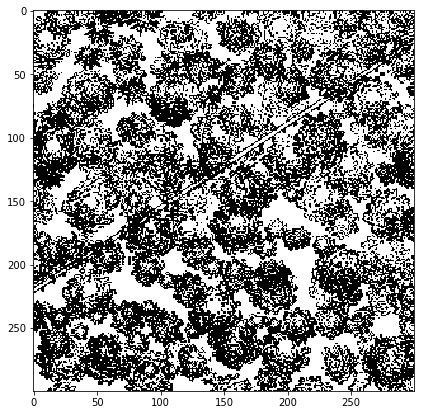

In [0]:
# Solution here (dont' cheat)
img1_inv = 255 - abs(img_slice1) 
img2_inv = 255 - abs(img_slice2)
added_image = img1_inv+img2_inv
plt.figure(figsize=(7,7))
plt.imshow(added_image,cmap="Greys")

Ok, nice, but actually, things could be even simpler. The one-liner below achieves the same result!

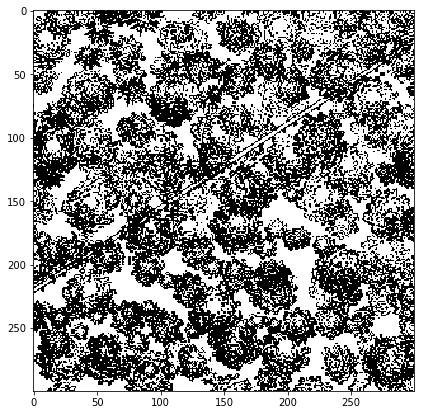

In [0]:
plt.figure(figsize=(7,7))
plt.imshow(img_slice1*img_slice2,cmap='Greys_r')

#### Exercise

Imagine that `img_slice1` and `img_slice2` describe the same area at different points in time. We can visualise the change by multiplying `img_slice1` and `img_slice2` and then subtracting `img_slice2` (effectively making these pixels more visible!).


In [0]:
# enter code here


Solution below.

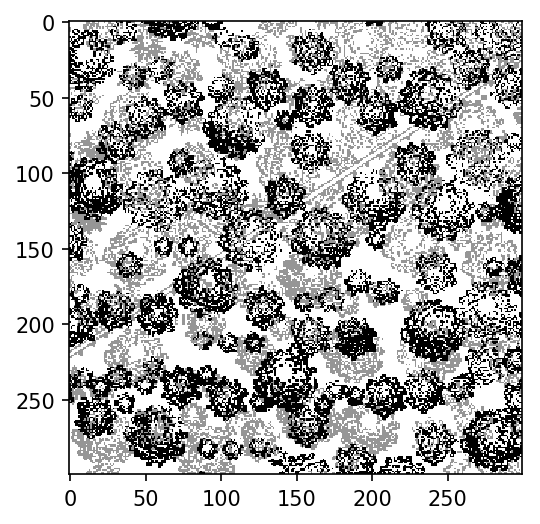

In [0]:
plt.figure(dpi=150)
plt.imshow((img_slice1*img_slice2) - img_slice2,cmap='Greys_r')

#### Question

Can you explain the differences between the figures produced by the matrix operations?

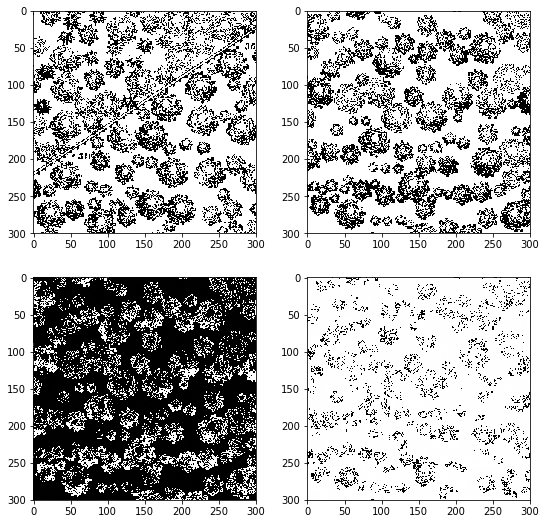

In [0]:
f, axarr = plt.subplots(2,2,figsize=(9,9))
axarr[0,0].imshow(img_slice1,cmap='Greys_r')
axarr[0,1].imshow(img_slice2,cmap='Greys_r')
axarr[1,0].imshow(img_slice1-img_slice2,cmap='Greys_r')
axarr[1,1].imshow(img_slice1+img_slice2,cmap='Greys_r')


Write your **answer** here.

## Applying Convolutions to Images (or: "Photoshop for free!")

### Basic Terminology


By now, you should feel comfortable talking about images as matrices (or even tensors) and anticipate the visual ramifications of specific matrix operations  (such as combining different matrices). When combined in an intelligent setup, these simple techniques can help us extracting valuable information from maps. For example, we have seen how multiplying and subtracting images and visualises changes (over imagined time).

But we can do more. Below, we focus on the concept of **convolution** and how this technique helps us to blur images or detect edges. 

To understand how convolution works, just stare at the .gif file below for about twenty minutes.

<img src="http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif"> 

The gorgeous .gif is taken from [this](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution) page.

To introduce some terminology:

- **Kernel**: the sliding window in the figure is commonly called a kernel or a  filter. 
- **Convolution**: is the process of sliding the filter over the matrix, multiply the values **element-wise** and sum them up. 
- The result--the matrix on the left--is called a **feature map**.

We could build a convolution script from scratch (and we invite you to do so), but for the sake of efficiency, we rely on a prefabricated function from the `scipy` library. Run the cell below to load the `convolve2d` function.

In [0]:
from scipy.signal import convolve2d

As an example, we can now reproduce the process shown in the gorgeous .gif above.

The only things we need to do is manually create

-  a 5x5 matrix
- and a 3x3 filter

In [0]:
matrix = np.array([[1,1,1,0,0],
                   [0,1,1,1,0],
                   [0,0,1,1,1],
                   [0,0,1,1,0],
                   [0,1,1,0,0]
                  ])

#### Exercise

Can you manually make the kernel (or filter) used in the figure above?


In [0]:
# enter code here


Solution below.

In [0]:
kernel = np.array([[1,0,1],
                   [0,1,0],
                   [1,0,1]])

Now, we can slide the kernel over the matrix--the result should be the same as the output at the right-hand side of the visualisation. 



In [0]:
convolve2d(matrix,kernel,mode='valid')

array([[4, 3, 4],
       [2, 4, 3],
       [2, 3, 4]])

To better understand the parameters that `convolve2d` allows you to play with, simply call the `help()` function!

In [0]:
help(convolve2d)

Help on function convolve2d in module scipy.signal.signaltools:

convolve2d(in1, in2, mode='full', boundary='fill', fillvalue=0)
    Convolve two 2-dimensional arrays.
    
    Convolve `in1` and `in2` with output size determined by `mode`, and
    boundary conditions determined by `boundary` and `fillvalue`.
    
    Parameters
    ----------
    in1 : array_like
        First input.
    in2 : array_like
        Second input. Should have the same number of dimensions as `in1`.
    mode : str {'full', 'valid', 'same'}, optional
        A string indicating the size of the output:
    
        ``full``
           The output is the full discrete linear convolution
           of the inputs. (Default)
        ``valid``
           The output consists only of those elements that do not
           rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
           must be at least as large as the other in every dimension.
        ``same``
           The output is the same size as `in1`

### Blurring

Armed with a battery of kernels and the convolution algorithm, we can start seriously manipulating our poor maps. A common example is blurring/dilating an image.

As in the previous example, we show how this works on a specific segment of the map, saved in a variable with the name `img_slice`

In [0]:
img_slice = image[1000:1300,1000:1300].copy()

Below we
- define the kernel
- slide the kernel over the image
- directly compare the effect of the filter by plotting the original and blurred image next to each other

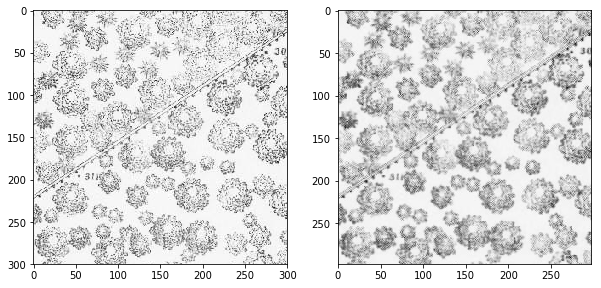

In [0]:
blur_kernel = np.array([[0,1,0],[1,0,1],[0,1,0]])
convolved_image = convolve2d(img_slice,blur_kernel,mode='valid')
f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(img_slice,cmap='Greys_r')
axarr[1].imshow(convolved_image,cmap='Greys_r')

#### Exercise

Sharpen the image using the filter depicted below

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/beb8b9a493e8b9cf5deccd61bd845a59ea2e62cc">

In [0]:
# enter code here

#### Exercise

Apply [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) by applying the filter below

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/c1e0a314554ab3663f129961ebd28fec307e74c4">

In [0]:
# enter code here

### Edge detection

Another common application of convolution is [edge detection](https://en.wikipedia.org/wiki/Edge_detection). The procedure is technically similar to blurring, we simply have to plug in other filters.

Let's work with a slightly different example and load another image `image2` by running the cell below.

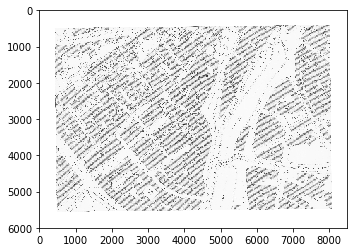

In [0]:
image2 = cv.imread("101965802.27_conv.jpeg",cv.IMREAD_GRAYSCALE)
img_slice = image2[100:1400,1700:2200].copy()
plt.imshow(image2,cmap='Greys_r')

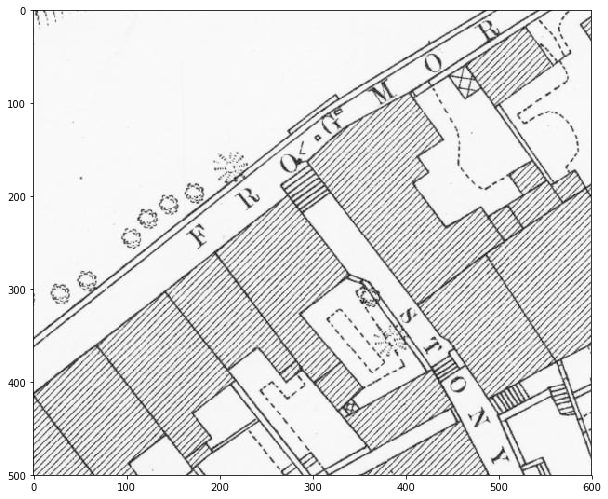

In [0]:
img2_segment = image2[1000:1500,1700:2300].copy()
plt.figure(figsize=(10,10))
plt.imshow(img2_segment,cmap='Greys_r')

An edge can be defined as a sudden change in the pixel intensity function. 

To understand what this means, let's look at a very simple image. 

In the figure below, the vertical line can be understood as creating two edges.

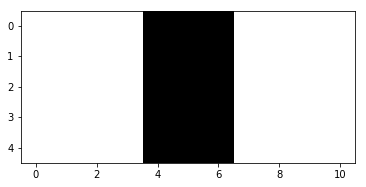

In [0]:
toy_image = np.array([[255,255,255,255,0,0,0,255,255,255,255],
                      [255,255,255,255,0,0,0,255,255,255,255],
                      [255,255,255,255,0,0,0,255,255,255,255],
                      [255,255,255,255,0,0,0,255,255,255,255],
                      [255,255,255,255,0,0,0,255,255,255,255]])
plt.imshow(toy_image,cmap='Greys_r')
       

Given the above image, the pixel intensity function will take the shape of the line plot below, which shows the average pixel intensity over the columns.

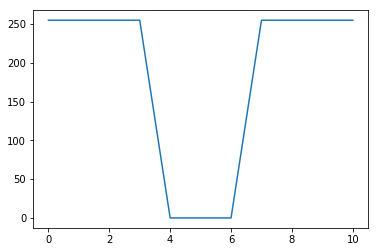

In [0]:
plt.plot(np.mean(toy_image,axis=0))

An edge detection kernel returns low values for regions where the pixel intensity function is flat and high values for locations that exhibit sudden drops or increases in pixel intensity.



The most common edge detection algorithms come in the following shapes:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/485992cb4024ac032e53eea37c24c30829cdfed6">

From [WildML](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/) "To understand this [filter workds] intuitively, think about what happens in parts of the image that are smooth, where a pixel color equals that of its neighbors: The additions cancel and the resulting value is 0, or black. If there’s a sharp edge in intensity, a transition from white to black for example, you get a large difference and a resulting white value)

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f800ad5f76b6c26c729ff0c1fef44284d7cade7a">

We can apply these filters to our toy example to detect the edges in a very simple figure.

[[   0    0  765 -765    0 -765  765    0    0]
 [   0    0  765 -765    0 -765  765    0    0]
 [   0    0  765 -765    0 -765  765    0    0]]


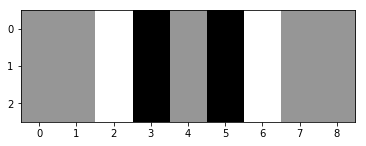

In [0]:
filter_test = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
edge_test = convolve2d(toy_image,filter_test,mode='valid')
print(edge_test)
plt.imshow(edge_test,cmap="Greys_r")

#### Exercise

Let's apply the filters to `img2_segment` and inspect the result!

- Compare the two edge detection filters directly (i.e. in one plot). Which one works best do you think?

**Hint**: increase `dpi` in `plt.subplots` to inspect the results. Do play with other regions of the map to understand how the filter works...

In [0]:
# insert code here

### Sobel Operator

The code below implements another popular edge detection algorithm, the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator). The code is inspired on [this blog](http://www.adeveloperdiary.com/data-science/computer-vision/how-to-implement-sobel-edge-detection-using-python-from-scratch/) post. Most of the code should look familiar by now!



In [0]:

filter_kernel_x = np.array([[1,0,-1],
                            [2,0,-2],
                            [1,0,-1]])

filter_kernel_y = np.array([[1,2,1],
                            [0,0,0],
                            [-1,-2,-1]])

img_slice =  image2[1100:1400,1700:2200].copy()
img_convolved_x = convolve2d(img_slice,filter_kernel_x)
img_convolved_y = convolve2d(img_slice,filter_kernel_y)

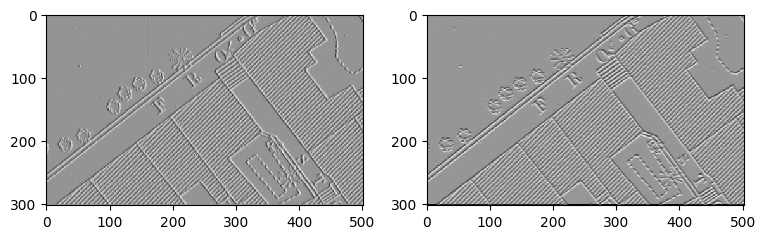

In [0]:

f,axarr = plt.subplots(1,2,dpi=100,figsize=(9,9))
axarr[0].imshow(img_convolved_x,cmap='Greys_r')
axarr[1].imshow(img_convolved_y,cmap='Greys_r')

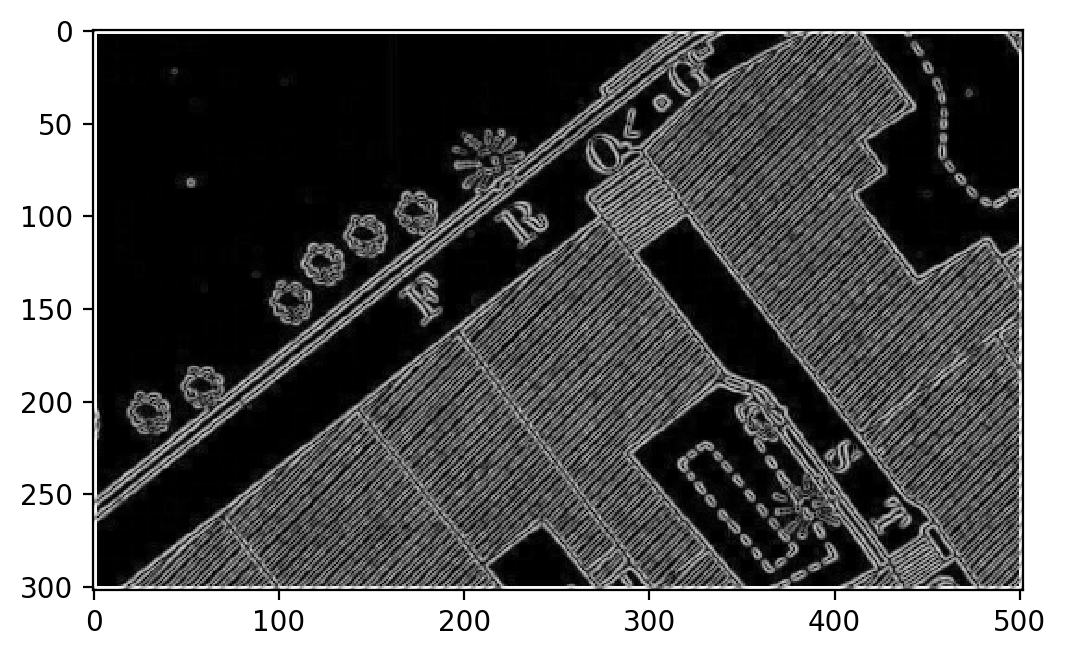

In [0]:
gradient_magnitude = np.sqrt(np.square(img_convolved_x) + np.square(img_convolved_y)) 
gradient_magnitude *= 255.0 / gradient_magnitude.max()
plt.figure(dpi=200)
plt.imshow(gradient_magnitude,cmap='Greys_r')

## Turbo-charging your skills with OpenCV

Code below is inspired on [this](https://buildmedia.readthedocs.org/media/pdf/opencv-python-tutroals/latest/opencv-python-tutroals.pdf) tutorial.

Load images from the [screenshots folder](https://drive.google.com/drive/folders/1br3Azp4VYGd1tJCE42TcCBN16xYhsWaR?usp=sharing)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving LondonExample.png to LondonExample.png
Saving LondonExampleII.png to LondonExampleII.png


In [0]:
import cv2 as cv
import matplotlib.pyplot as plt

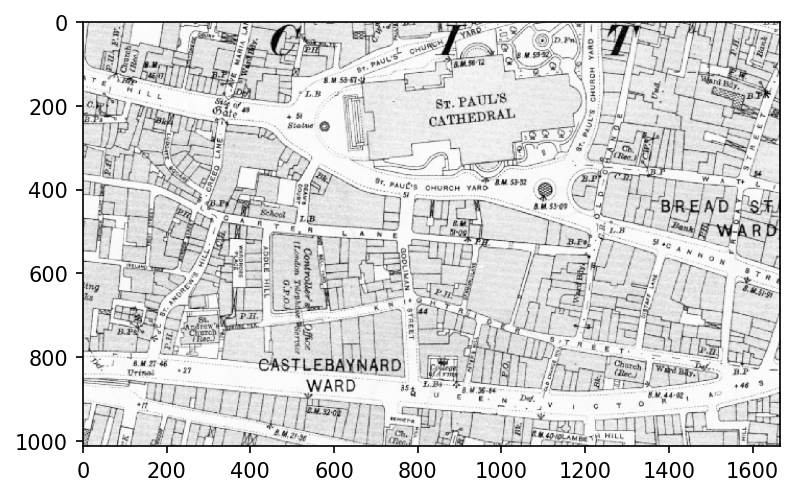

In [0]:
img = cv.imread('LondonExample.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plt.figure(dpi=150)
plt.imshow(gray,cmap="Greys_r")

### Thesholding

[Otsu's](https://en.wikipedia.org/wiki/Otsu%27s_method) thresholding.

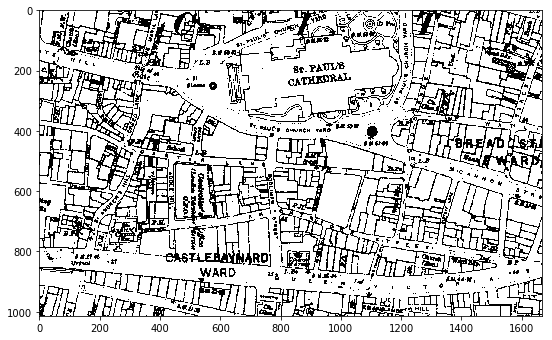

In [0]:
ret,thresh = cv.threshold(gray.copy(),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.figure(figsize=(9,9))
plt.imshow(thresh,cmap="Greys_r")

### Edge Detection

OpenCV implements many of the algorithms we invoked earlier, but also allows us to apply some more complicated versions, without having to write a lot of code. Applying a [Laplacian](https://en.wikipedia.org/wiki/Edge_detection) edge detection algorithm, can be done in just one line.

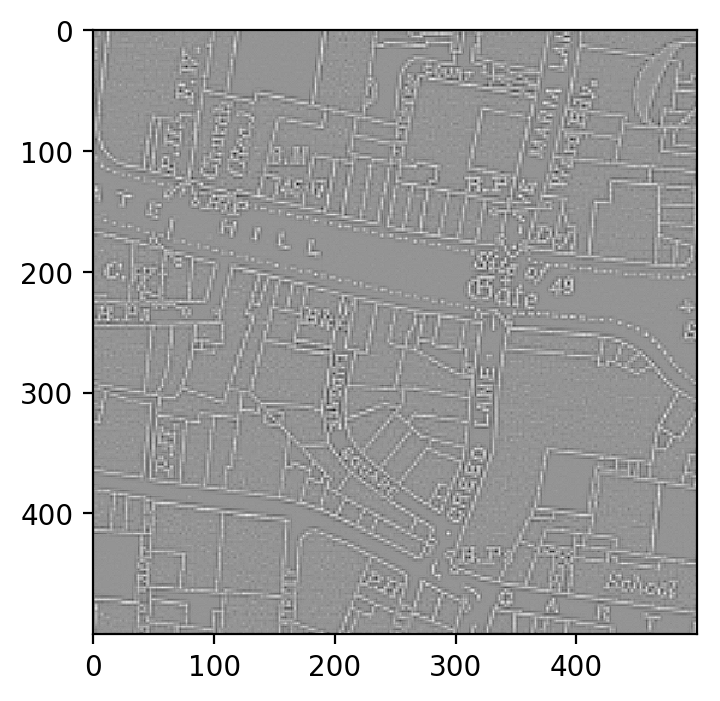

In [0]:
laplacian = cv.Laplacian(gray[:500,:500],cv.CV_32F)
plt.figure(dpi=200)
plt.imshow(laplacian,cmap="Greys_r")

[Canny](https://en.wikipedia.org/wiki/Canny_edge_detector) edge detection is even cooler.

In [0]:
help(cv.Canny)

Help on built-in function Canny:

Canny(...)
    Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]]) -> edges
    .   @brief Finds edges in an image using the Canny algorithm @cite Canny86 .
    .   
    .   The function finds edges in the input image and marks them in the output map edges using the
    .   Canny algorithm. The smallest value between threshold1 and threshold2 is used for edge linking. The
    .   largest value is used to find initial segments of strong edges. See
    .   <http://en.wikipedia.org/wiki/Canny_edge_detector>
    .   
    .   @param image 8-bit input image.
    .   @param edges output edge map; single channels 8-bit image, which has the same size as image .
    .   @param threshold1 first threshold for the hysteresis procedure.
    .   @param threshold2 second threshold for the hysteresis procedure.
    .   @param apertureSize aperture size for the Sobel operator.
    .   @param L2gradient a flag, indicating whether a more accurate \

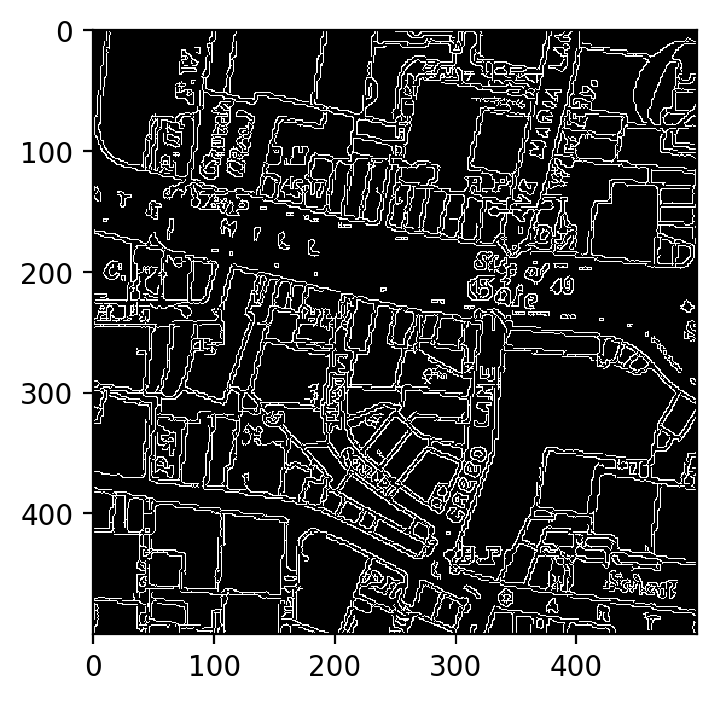

In [0]:
img = cv.imread('LondonExample.png')
canny = cv.Canny(img[:500,:500],0, 255)
plt.figure(dpi=200)
plt.imshow(canny,cmap="Greys_r")

### Segmentation

#### Contours

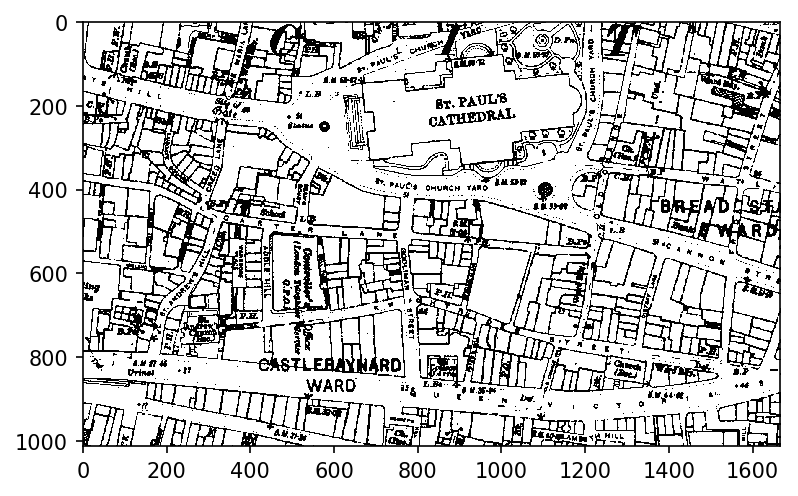

In [0]:
img = cv.imread('LondonExample.png')
imgray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(imgray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.figure(dpi=150)
plt.imshow(thresh,cmap='Greys_r')

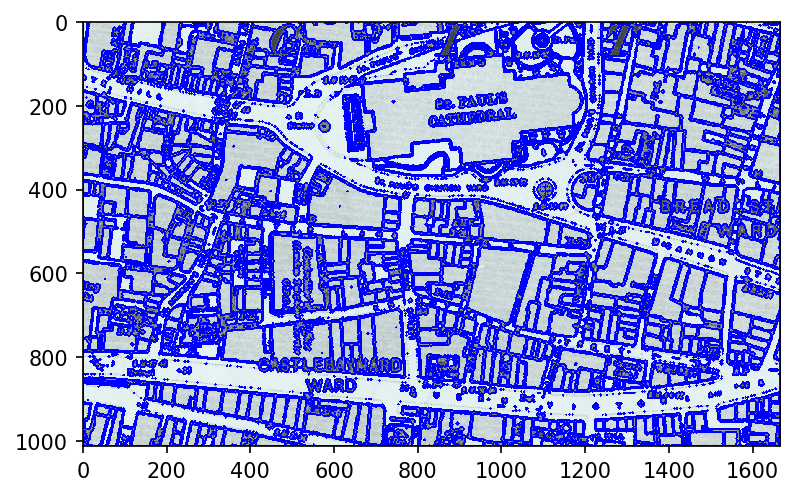

In [0]:
image, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img, contours, -1, (0,0,255), 3)
plt.figure(dpi=150)
plt.imshow(img)

In [0]:
cnt = contours[5]
print(cnt.shape)
print(cnt)

(2, 1, 2)
[[[1615 1009]]

 [[1620 1009]]]


Find the contour with highest number of rows.

In [0]:
contours.sort(key=lambda x: x.shape[0])
contours[-10].shape

(464, 1, 2)

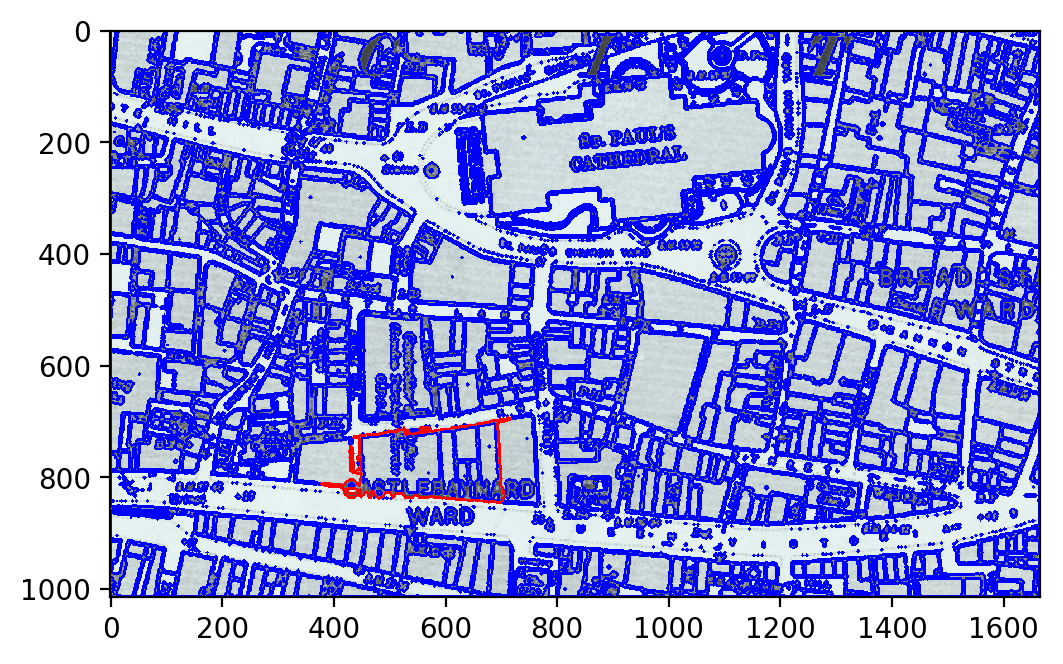

In [0]:
x = cv.drawContours(img, [contours[-10]], 0, (255,0,0), 3)
plt.figure(dpi=200)
plt.imshow(x)

#### Analyzing contours

In [0]:
M = cv.moments(contours[-10])
print(M)

{'m00': 31881.0, 'm10': 18336972.833333332, 'm01': 24731796.5, 'm20': 10734728079.666666, 'm11': 14218763742.0, 'm02': 19227655361.666664, 'm30': 6388130546417.95, 'm21': 8320871618017.967, 'm12': 11050100408246.9, 'm03': 14980782334380.65, 'mu20': 187864032.41580582, 'mu11': -6206633.459629059, 'mu02': 41878312.09443283, 'mu30': -2262869334.5771484, 'mu21': 508749510.690979, 'mu12': 572738969.5768967, 'mu03': -112598709.2734375, 'nu20': 0.1848331093308677, 'nu11': -0.006106498120306084, 'nu02': 0.04120266417368384, 'nu30': -0.012468942977941903, 'nu21': 0.0028033296231163313, 'nu12': 0.0031559266121894817, 'nu03': -0.0006204454070180357}


In [0]:
M['m00']

31881.0

In [0]:
area = cv.contourArea(contours[-10])
print(area)

31881.0


Find the largest contour!

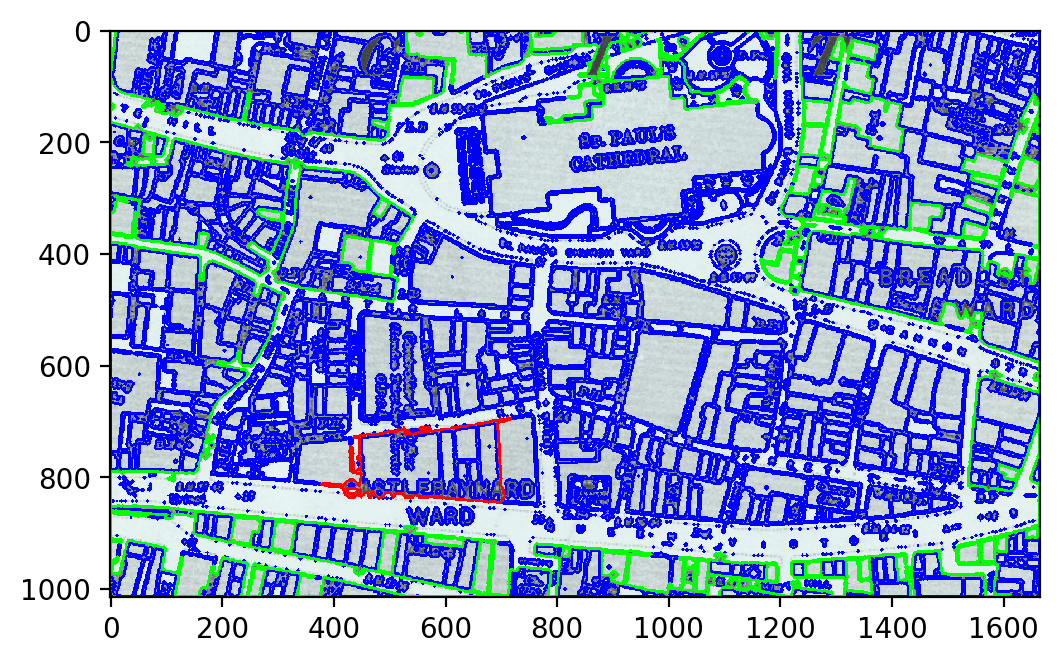

In [0]:
contours.sort(key=cv.contourArea,reverse=True)
cv.contourArea(contours[3])
x = cv.drawContours(img, [contours[0]], 0, (0,255,0), 3)
plt.figure(dpi=200)
plt.imshow(x)

Experiment with other [contour features](https://docs.opencv.org/3.4.2/dd/d49/tutorial_py_contour_features.html)

In [0]:
# here!

#### Watershed

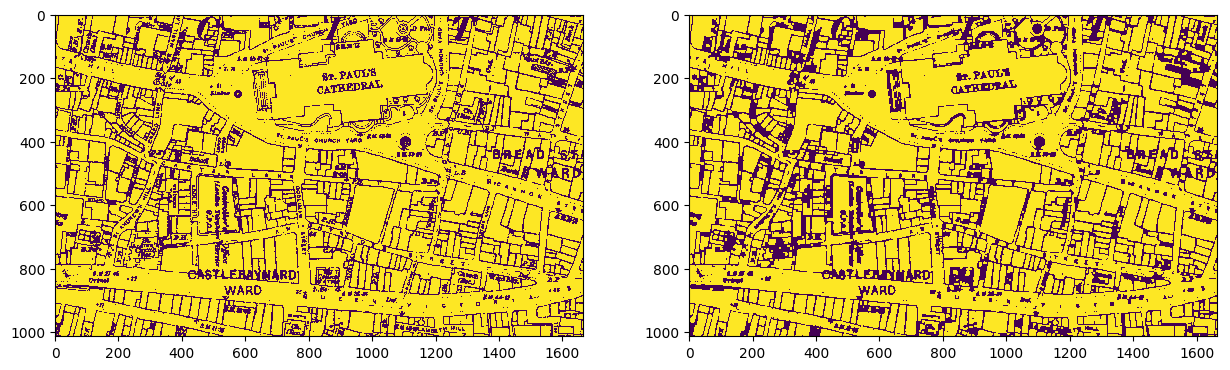

In [0]:
# threshold figure
ret,thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

# plot images
f,axarr = plt.subplots(1,2,dpi=100,figsize=(15,20))
axarr[0].imshow(thresh)
axarr[1].imshow(opening)


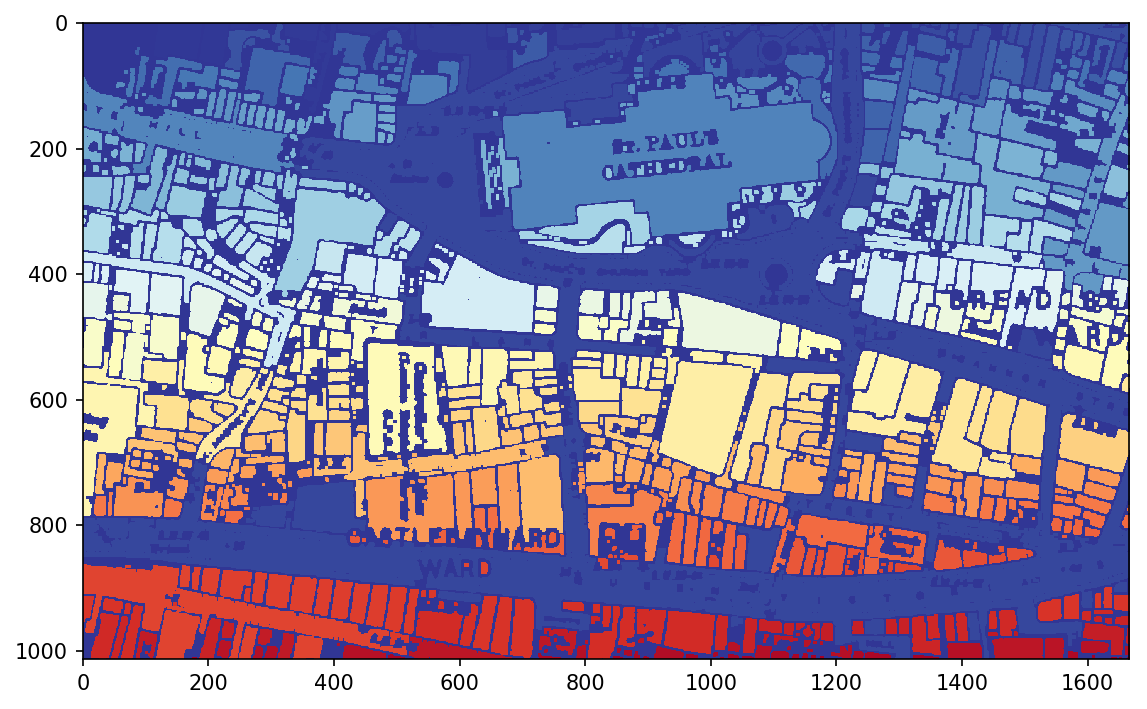

In [0]:
# Marker labelling
ret, markers = cv.connectedComponents(opening) #
plt.figure(dpi=150,figsize=(9,12))
plt.imshow(markers,cmap='RdYlBu_r')


# Appendix
## Resizing images

We prepared resized images for this Hackday. Working with .tiffs that are mostly larger than 500MB pushes Colab to the edge of its capabilities (uploading the file takes way too long). 

The script to resize images can be found below (appendix), for those who are a bit more comfortable with Python, feel free to copy-paste this script and experiment with other images.

In [0]:
import cv2 as cv
import os
from PIL import Image

def rescale_grayscale_from_path(path,scale=0.1,extension="_conv",out_format="jpeg",out_folder='./'):
    """given path to an image, rescale and saves the image.
    Args:
        path (str): /path/to/tiff/file
        scale (float): factor for rescaling
        extension (str): extension appended to the processes image
        out_format (jpeg, png): format of the output file
        
    """
    image = cv.imread(path)
    
    print("Size before rescaling =",image.shape)
    
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_name = '.'.join(path.split("/")[-1].split(".")[:-1])
    gray_image_small = cv.resize(gray_image, dsize = None, fx = scale, fy = scale)
    
    print("Size after rescaling =",gray_image_small.shape)
    
    gray_image_small_pillow = Image.fromarray(gray_image_small)
    out_path = os.path.join(out_folder, image_name+ extension + "q={}".format(scale) +"." + out_format)
    gray_image_small_pillow.save(out_path,format=out_format, quality=50)
    
    print('Done. Save file to "{}"'.format(out_path))
    
#path = "./maps/101168393.1.tif"# example use, delete fist hashtag to run
#rescale_grayscale_from_path(path,1.0,out_folder='./maps/quality_comparison')  # example use, delete fist hashtag to run
